# Introduction


**What?** Predicting a slowly decaying trend with Multi-Step LSTM Models



# Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import numpy as np
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# Helper functions

In [2]:
def plotLearningHistory(history, useLogScale = False):
    """Plot learning history.
    """
    
    epochs = len(history.history[ "loss"]) 
    x = range(0, epochs)

    rcParams['figure.figsize'] = 15, 5
    rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    ax.plot(x, history.history[ "loss"], 'r-', lw = 3, label = 'Train') 

    ax.legend() 
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.title('Training history')

    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.minorticks_on()
    
    if useLogScale == True:
        plt.yscale('log')
    plt.show()

# Create the dataset


- We want to create a time series that has a constant decay over time which we can predict with a naked eye.
- The goal is to see if a LSTM model can learn the trend and provide a multi-step prediction into the future. 
- To render the problem a little **bit more challenging** we have addded some noise. This was sampled randomly from a normal distribution.



667 667


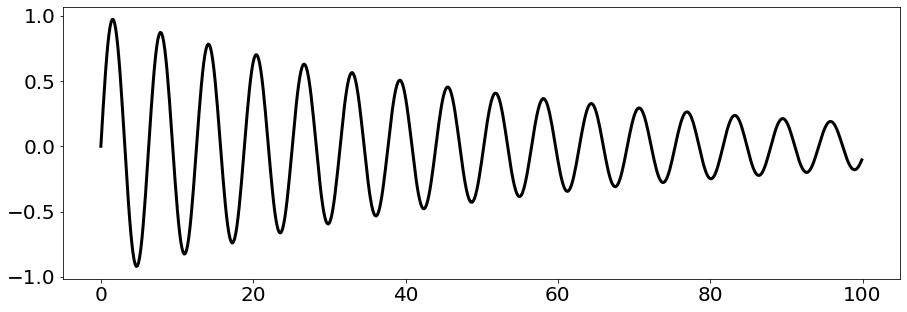

In [87]:
def SinDumpedSignal(n_max,factor):
    """Sine dumped signal
    """
    n = np.arange(0,n_max, 0.15)
    return n, np.sin(n) * 2 ** (-n * factor)

X, Y = SinDumpedSignal(100, 0.025)
print(len(X), len(Y))
plt.plot(X, Y, "-k", lw = 3);

In [95]:
noise = np.random.normal(0,0.015,len(Y))

In [96]:
df = pd.DataFrame()
df["cycle"] = np.array(X) 
df["response"] = np.array(Y)
df["responsePlusNoise"] = np.array(Y) + noise

In [97]:
df = df.dropna(how = 'any', axis = 0) 

In [98]:
df.head(5)

,cycle,response,responsePlusNoise
0,0.00,0.000000,0.040500
1,0.15,0.149050,0.158722
2,0.30,0.293988,0.302044
3,0.45,0.431587,0.433461
4,0.60,0.558802,0.567890


In [99]:
df.shape

(667, 3)

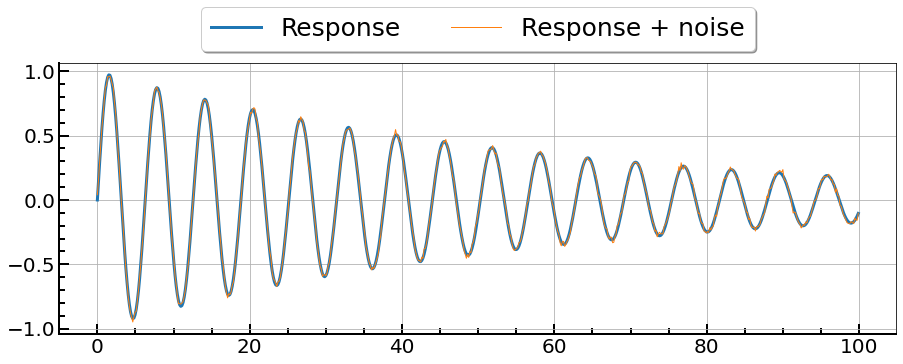

In [100]:
fig = plt.figure() 
ax = fig.add_subplot(111) 
        
plt.plot(df["cycle"], df["response"], "-", lw = 3, label = "Response")
plt.plot(df["cycle"], df["responsePlusNoise"], "-", lw = 1, label = "Response + noise")

ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid()
ax.minorticks_on()
ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.25),
          ncol = 2, fontsize = 25, fancybox=True, shadow=True)

# LSTM model


- A **multi-step** time series forecasting problem requires a prediction of multiple time steps into the future.

- There are **two main types** of LSTM models that can be used for multi-step forecasting; they are:
    - Vector Output Model
    - Encoder-Decoder Model

- We'll concentrate on the first one.
  


In [10]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    
    """Split a univariate sequence into samples
    
    sequence = univariate series, meaning there is only
    one target we'd like to predict
    n_step_in = how many step back do you want to keep?
    n_step_out = howm any steps forwrd do you want to keep?
    """
    
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [106]:
# To see how this re-arrange the sequence consider this exampple
seqTest = range(10)
inputs, outputs = split_sequence(seqTest, 4, 3)
for i in range(len(inputs)):
    print(inputs[i], outputs[i])

[0 1 2 3] [4 5 6]
[1 2 3 4] [5 6 7]
[2 3 4 5] [6 7 8]
[3 4 5 6] [7 8 9]



- One of the question I still need to answer is the following: is **n_steps_in < n_steps_out** a rule? 
- Does it come from common sense?
- In our case we'd like to look anything between 50 to 100 steps into the future.



In [107]:
seq = df["responsePlusNoise"]
print(len(seq))

667


In [108]:
n_steps_in, n_steps_out = 80, 25
X, y = split_sequence(seq, n_steps_in, n_steps_out)

In [109]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(563, 80, 1)

In [52]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(150, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [53]:
# Fit model
history = model.fit(X, y, epochs = 25, verbose = 1)

Epoch 1/25
18/18 [==============================] - 5s 97ms/step - loss: 0.1451
Epoch 2/25
18/18 [==============================] - 2s 108ms/step - loss: 0.0753
Epoch 3/25
18/18 [==============================] - 2s 108ms/step - loss: 0.0837
Epoch 4/25
18/18 [==============================] - 2s 116ms/step - loss: 0.0802
Epoch 5/25
18/18 [==============================] - 2s 101ms/step - loss: 0.1093
Epoch 6/25
18/18 [==============================] - 2s 94ms/step - loss: 0.0896
Epoch 7/25
18/18 [==============================] - 2s 108ms/step - loss: 0.0706
Epoch 8/25
18/18 [==============================] - 2s 98ms/step - loss: 12.7915
Epoch 9/25
18/18 [==============================] - 2s 100ms/step - loss: 0.0938
Epoch 10/25
18/18 [==============================] - 2s 94ms/step - loss: 0.0914
Epoch 11/25
18/18 [==============================] - 2s 96ms/step - loss: 0.0549
Epoch 12/25
18/18 [==============================] - 2s 95ms/step - loss: 0.0333
Epoch 13/25
18/18 [===========

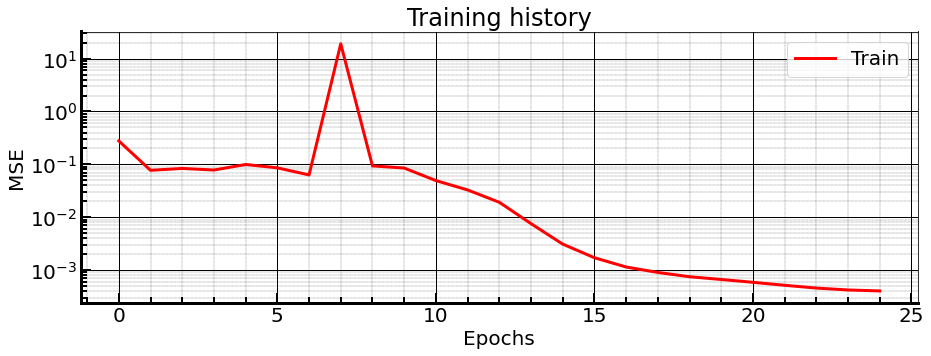

In [54]:
plotLearningHistory(history, useLogScale = True)

# In-sample prediction


- In-sample prediction means we are going to see how well the model predicts data that it has seen before.
- We'll consider the last part of the series **-1**.
- Remember that that we are using 50 samples before to predict 25 after. `n_steps_in, n_steps_out = 50, 25`



In [55]:
y[-1]

array([ 0.17216668,  0.18849808,  0.14490871,  0.10762716,  0.07710976,
        0.06084898,  0.03455247, -0.00852739, -0.03278464, -0.05086587,
       -0.08232314, -0.10285668, -0.12240601, -0.13059962, -0.15292491,
       -0.17308764, -0.19881905, -0.2004686 , -0.17796506, -0.13792943,
       -0.16467518, -0.18285069, -0.12608595, -0.10742768, -0.09894089])

In [56]:
# We are using reshape(-1,) just because it easier to print the results
X[-1].reshape(-1,)

array([ 1.37345940e-01,  9.09367142e-02,  4.29086734e-02,  1.06408674e-02,
       -1.25024431e-02, -3.09278918e-02, -1.00153771e-01, -1.44760370e-01,
       -1.32846997e-01, -1.90133028e-01, -1.71990943e-01, -2.25630675e-01,
       -1.79232389e-01, -2.04120428e-01, -2.11355132e-01, -2.23388054e-01,
       -2.31305064e-01, -2.04860509e-01, -2.04590886e-01, -1.57420013e-01,
       -1.38236840e-01, -1.42488327e-01, -9.71871476e-02, -6.73935731e-02,
       -4.01475677e-02,  2.87690230e-02,  4.26397062e-02,  1.02716818e-01,
        1.01979468e-01,  1.31206105e-01,  1.26900258e-01,  1.63222541e-01,
        1.80797636e-01,  2.01813339e-01,  1.90778575e-01,  2.14690024e-01,
        2.04525874e-01,  1.93235255e-01,  2.00970919e-01,  1.77879371e-01,
        1.52894742e-01,  1.33851176e-01,  1.01118068e-01,  9.01506946e-02,
        4.35065006e-02,  3.49230245e-02, -1.81659832e-04, -4.15366027e-02,
       -8.55045599e-02, -1.05798529e-01, -1.20887118e-01, -1.41069754e-01,
       -1.50453997e-01, -

In [57]:
# Demonstrate prediction
x_input = X[-1]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose = 0)
print(yhat[0])

[ 0.16322193  0.15892263  0.13147256  0.09537388  0.09574226  0.05517787
  0.0339757   0.00678884 -0.01426759 -0.04002497 -0.06169293 -0.08997865
 -0.11555837 -0.13925059 -0.15212345 -0.17066267 -0.17536883 -0.17191106
 -0.17246623 -0.18629304 -0.15172312 -0.13779522 -0.16020462 -0.12909484
 -0.11292959]


In [58]:
for i in range(len(yhat[0])):
    print("Target: ", str(y[-1][i]), ", predicted: ", str(yhat[0][i]))

Target:  0.17216668236709748 , predicted:  0.16322193
Target:  0.18849808488326403 , predicted:  0.15892263
Target:  0.14490870591777402 , predicted:  0.13147256
Target:  0.10762716396488362 , predicted:  0.095373884
Target:  0.07710975981353467 , predicted:  0.09574226
Target:  0.06084897843677487 , predicted:  0.05517787
Target:  0.03455247112656205 , predicted:  0.033975698
Target:  -0.008527393754942287 , predicted:  0.006788836
Target:  -0.03278464048510227 , predicted:  -0.01426759
Target:  -0.050865866273952114 , predicted:  -0.040024966
Target:  -0.08232314328994053 , predicted:  -0.06169293
Target:  -0.10285667545482982 , predicted:  -0.08997865
Target:  -0.12240601012128449 , predicted:  -0.11555837
Target:  -0.13059962372817388 , predicted:  -0.13925059
Target:  -0.15292490672010053 , predicted:  -0.15212345
Target:  -0.17308763537443195 , predicted:  -0.17066267
Target:  -0.19881905396946808 , predicted:  -0.17536883
Target:  -0.20046859904397651 , predicted:  -0.17191106
T

In [59]:
# Predicting the accuracy
print("MSE= ", mean_squared_error(y[-1], yhat[0]))
print("MSE= ", mean_absolute_error(y[-1], yhat[0])) 

MSE=  0.0004336581246070141
MSE=  0.016785988421017264


# In-sample prediction


- In-of-sample prediction are those predictions the model has seen before.
- So we have **80 steps** as input for **25 steps** as output. 
- We'd lilke to see if the model can predict the last 25 value of the series. This means we need to feed the previous 80 points which exaplains the `[-105:-25]`



In [69]:
n_steps_in

80

In [111]:
n_steps_out

25

In [114]:
x_input_new = []
for i in X[-1].reshape(-1,):
    x_input_new.append(i)
for j in y[-1]:
    x_input_new.append(j)

# we need the last 50 only
x_input_new = x_input_new[-105:-25]
print(len(x_input_new))  

x_input_new = np.array(x_input_new)
x_input_new = x_input_new.reshape((1, n_steps_in, n_features))
print(x_input_new.shape)
yhat_new = model.predict(x_input_new, verbose=0)

80
(1, 80, 1)


In [115]:
delta = df["cycle"].values[1] - df["cycle"].values[0]
delta

0.15

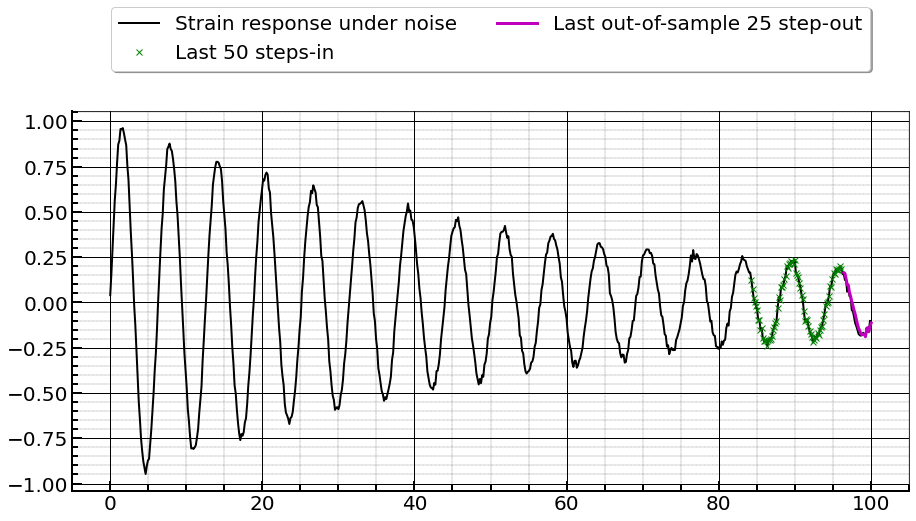

In [118]:
fig = plt.figure(figsize=(15, 7)) 
ax = fig.add_subplot(111) 

plt.plot(df["cycle"], df["responsePlusNoise"], "-k", lw = 2, label = "Strain response under noise")

a = df["cycle"].values
b = df["responsePlusNoise"].values


# We have taken the last 50 but keep in mind there is a lag
plt.plot(a[-105:-25], b[-105:-25], "gx", lw = 2, label = 'Last 50 steps-in')

c = []
dummy = 0
for i in range(len(yhat_new[-1])):
    dummy+=0.15
    c.append( dummy + a[-25])
    
plt.plot(c, yhat_new[0], "m-", lw = 3, label = 'Last out-of-sample 25 step-out')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 2, fancybox = True, shadow = True)

plt.grid(True)


- One interesting observation is that the prediction is always much more smooth than the actual training samples.
- Is that connected to the fact it is said the ANNs are said be good at **filtering out noise**?



# Predicting even more steps forward


- What if we want to predict even more steps?
- We have to decide whether we are going to retrain the model or not?
- In this cell we are **NOT** going to retrain the model and we'll check if the model has learnt the decay trend.
- **The important** point here is to understand that the output will eventually become inputs.



In [74]:
input_ = x_input_new.reshape(-1,1)
input_.shape
input_ = list(input_)
input_ = [i[0] for i in input_]

In [75]:
input_

[0.0287690229862382,
 0.04263970616880396,
 0.1027168177705552,
 0.10197946768840037,
 0.13120610453351617,
 0.12690025785553644,
 0.16322254115969467,
 0.18079763560747975,
 0.20181333923183922,
 0.1907785747356812,
 0.21469002369734877,
 0.20452587376705958,
 0.19323525496817623,
 0.20097091870855477,
 0.17787937073435606,
 0.15289474175256376,
 0.13385117595162027,
 0.1011180677009769,
 0.0901506946309418,
 0.04350650062671003,
 0.03492302451969731,
 -0.00018165983165767396,
 -0.04153660272532898,
 -0.08550455987250247,
 -0.10579852851470312,
 -0.12088711848084964,
 -0.14106975398597013,
 -0.15045399656411754,
 -0.18141019129982264,
 -0.19116114795249556,
 -0.2114815484981409,
 -0.2124566524332241,
 -0.15843306333085208,
 -0.16994529527687813,
 -0.17996254459626398,
 -0.1377009821634084,
 -0.11321587823188026,
 -0.134719585826141,
 -0.11359487465791604,
 -0.08254101903614249,
 -0.038642240543321764,
 -0.02714832070474285,
 0.022343189433978956,
 0.04801399549317349,
 0.0645334872038

In [83]:
loop = 15

counter = 0
import copy
x_input_new_ = copy.deepcopy(input_)
while counter < loop:
    counter +=1
    
    # We need the last 50 only (again)
    x_input_new_temp = x_input_new_[-80:]
    #print(x_input_new_temp.shape)
    # Make it an array
    x_input_new_temp = np.array(x_input_new_temp)
    #print(x_input_new_temp.shape)
    x_input_new_temp = x_input_new_temp.reshape((1, n_steps_in, n_features))
    #print(x_input_new_temp.shape)
    # new prediction
    yhat_new_temp = model.predict(x_input_new_temp, verbose=0) 
    #print(yhat_new_temp)
    #print(yhat_new_temp.shape)
    for k in yhat_new_temp[0]:
        #x_input_new = x_input_new
        #x_input_new = list(x_input_new)
        #print(x_input_new)
        
        x_input_new_.append(k)     

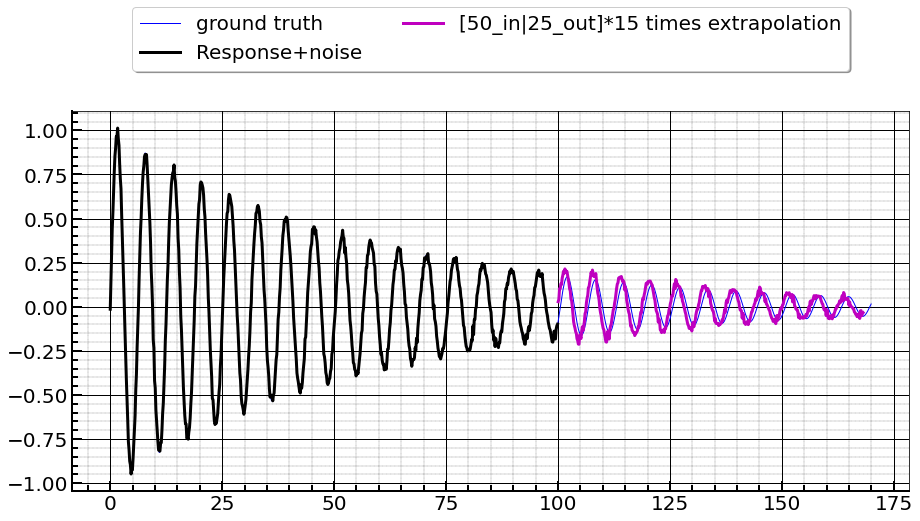

In [94]:
fig = plt.figure(figsize=(15, 7)) 
ax = fig.add_subplot(111) 

# We need this to se if the model has learnt the constant decay trend
xx, yy = SinDumpedSignal(170, 0.025)
plt.plot(xx, yy, "b-", lw = 1, label = "ground truth")


plt.plot(df["cycle"], df["responsePlusNoise"], "-k", lw = 3, label = "Response+noise")

a = df["cycle"].values
b = df["responsePlusNoise"].values


## We have taken the last 50 but keep in mind there is a lag
#plt.plot(a[-80:], b[-80:], "gx", lw = 2, label = 'Last 50 steps-in')

c = []
dummy = 0
for i in range(len(x_input_new_)):
    dummy+=delta
    c.append( dummy + a[-1])
    
plt.plot(c, x_input_new_, "m-", lw = 3, label = '[80_in|25_out]*'+str(loop)+" times extrapolation")




ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 2, fancybox = True, shadow = True)

plt.grid(True)

# Conclusions


- As you can see we extrapolate the whole trend.
- What is difficult is finding out the right inputs. Is the `80_in|25_out` optimal?
- The cherry on the cake, would be to add some PI to the prediction.
- Further, will the model learn a non-constant decay trend?

